#### Practical Machine Learning 
##### File: Recurrent Neural Networks : Example 1
##### Date: 2/11/2020
##### ALL RIGHTS RESERVED | DO NOT DISTRIBUTE
************************************************/   

In [1]:
#Recurrent Neural Networks(RNNs) are neural networks designed to deal with datasets whereby the sequence of the data can
#yield useful information. They are typically used in the context of time-series data, but is not strictly limited to it.
#Sequence can really mean anything in which order is important, such as music notes, text, board game moves, or in this 
#example, Arbritrary mathematical models.
#
#Base RNNs are a bit out-dated compared to GRUs and LSTMs, but still useful in cases where temporal dependancies are not 
#long(personal experience pegs this around high single digis), as the gradient of the loss function decays too rapidly for
#"memory" of data points too far sequentially for the model to associate any useful features between them. They tend to
#train faster than LSTMs and use less memory at runtime than LSTMs (depending on the complexity of the model of course).
#If you're okay with a longer training time however, LSTMs perform better, especially when sequence dependencies are long.
#This is primarily due to the gating and memory mechanisms.
#
#LSTMs tend to be more popular, hence we use an LSTM as an example here.

In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import random
import sys
!{sys.executable} -m pip install keras
import keras
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D,BatchNormalization
from tensorflow.keras.layers import Activation, Input, Add, LSTM
from tensorflow.keras import Model, Sequential



In [5]:
#Here we generate the data set. The arbitrary mathematical function is as follows:
#Current Data point = (2nd to last data point + 3rd to last data point + 1)/(last data point)
#Below we start with 3 data points and then we populate this bad boy

data = [0,1,2]

for i in range(1000):
    lastDataPoint = data[-1] #last data point
    lastDataPoint2 = data[-2] #2nd to last data point
    lastDataPoint3 = data[-3] #3rd to last data point
    currentData = (lastDataPoint2 + lastDataPoint3 + 1)/lastDataPoint
    data.append(currentData)

In [6]:
#Here we have an overview of the data
#As you can see, the formula was purposefully chosen so that the expected values during the testing phase are easy to
#debug/evaluate. It's simply a series of even numbers with the value 1 between them.
print(data)

[0, 1, 2, 1.0, 4.0, 1.0, 6.0, 1.0, 8.0, 1.0, 10.0, 1.0, 12.0, 1.0, 14.0, 1.0, 16.0, 1.0, 18.0, 1.0, 20.0, 1.0, 22.0, 1.0, 24.0, 1.0, 26.0, 1.0, 28.0, 1.0, 30.0, 1.0, 32.0, 1.0, 34.0, 1.0, 36.0, 1.0, 38.0, 1.0, 40.0, 1.0, 42.0, 1.0, 44.0, 1.0, 46.0, 1.0, 48.0, 1.0, 50.0, 1.0, 52.0, 1.0, 54.0, 1.0, 56.0, 1.0, 58.0, 1.0, 60.0, 1.0, 62.0, 1.0, 64.0, 1.0, 66.0, 1.0, 68.0, 1.0, 70.0, 1.0, 72.0, 1.0, 74.0, 1.0, 76.0, 1.0, 78.0, 1.0, 80.0, 1.0, 82.0, 1.0, 84.0, 1.0, 86.0, 1.0, 88.0, 1.0, 90.0, 1.0, 92.0, 1.0, 94.0, 1.0, 96.0, 1.0, 98.0, 1.0, 100.0, 1.0, 102.0, 1.0, 104.0, 1.0, 106.0, 1.0, 108.0, 1.0, 110.0, 1.0, 112.0, 1.0, 114.0, 1.0, 116.0, 1.0, 118.0, 1.0, 120.0, 1.0, 122.0, 1.0, 124.0, 1.0, 126.0, 1.0, 128.0, 1.0, 130.0, 1.0, 132.0, 1.0, 134.0, 1.0, 136.0, 1.0, 138.0, 1.0, 140.0, 1.0, 142.0, 1.0, 144.0, 1.0, 146.0, 1.0, 148.0, 1.0, 150.0, 1.0, 152.0, 1.0, 154.0, 1.0, 156.0, 1.0, 158.0, 1.0, 160.0, 1.0, 162.0, 1.0, 164.0, 1.0, 166.0, 1.0, 168.0, 1.0, 170.0, 1.0, 172.0, 1.0, 174.0, 1.0, 176.

In [7]:
#Here we generate the features and labels. We store it in the same list however, so during shuffling, the associated features
#and labels stay associated with each other. Note that although we used 3 previous data points to generate the next data
#point, it is not necessary that we do the same when we make the predictive model. For instance, in this example we will 
#be using the previous 5 data points to predict the next one. The script has been coded so that this value can be changed 
#pretty easily, just rerun the kernals after changing the numData variable. Generally speaking, the more previous data 
#points used, the better the prediction. Keep this in mind when dealing with more complicated(multivariate, long-time 
#dependent) datasets. Though be warned, models that use excessively long series to generate predictions seem to be prone to
#overfitting, so use regularization methods (batch normalization, L2 regularization, ect...) when doing so.

numData = 5 #Change this value if you wish to use a longer sequence to generate the model
trainData = []
valData = []
testData = []

#train data population
for i in range(800-numData):
    tempList = []
    for j in range(numData):
        tempData = data[i+j]
        tempList.append(tempData)
    label = data[i+numData]
    tempList.append(label)
    trainData.append(tempList)
    
#val data population
for i in range(100-numData):
    i = i + len(trainData)
    tempList = []
    for j in range(numData):
        tempData = data[i+j]
        tempList.append(tempData)
    label = data[i+numData]
    tempList.append(label)
    valData.append(tempList)
    
#test data population
for i in range(100-numData):
    i = i + len(trainData) + len(valData)
    tempList = []
    for j in range(numData):
        tempData = data[i+j]
        tempList.append(tempData)
    label = data[i+numData]
    tempList.append(label)
    testData.append(tempList)

In [8]:
#here we double check population of data sets and shuffle them. Shuffling when dealing with time-dependant series must be
#done with caution, as the associated data points must stick together!
print(len(trainData))
print(len(valData))
print(len(testData))

#shufflings done here
random.shuffle(trainData)
random.shuffle(valData)
random.shuffle(testData)

795
95
95


In [9]:
#data set seperated into features and labels done here. Note that this must occur AFTER shuffling so that the labels and
#features stay associated with each other. A function is used to reduce
def extractFeaturesLabels(data):
    featuresList = []
    labelsList = []
    for i in range(len(data)):
        features = data[i][:numData]
        label = data[i][-1]
        featuresList.append(features)
        labelsList.append(label)
    return np.array(featuresList), np.array(labelsList)


trainFeatures, trainLabels = extractFeaturesLabels(trainData)
valFeatures, valLabels = extractFeaturesLabels(valData)
testFeatures, testLabels = extractFeaturesLabels(testData)

In [10]:
#Most neural network layers are extremely picky about the dimensions of the input layers. Here we reshape the numpy arrays
#to ensure that they fit. For this particular dataset it isn't difficult - for series data that exhibit high dimensionality
#certain precautions may have to be taken.
trainFeatures = trainFeatures.reshape(len(trainData),numData,1)
valFeatures = valFeatures.reshape(len(valData),numData,1)
testFeatures = testFeatures.reshape(len(testData),numData,1)

In [11]:
#Here we have a preview of a sample of features and labels. The label should be the following value in the sequence, if it
#is something messed up.
print(trainFeatures[11])
print(trainLabels[11])

[[  1.]
 [268.]
 [  1.]
 [270.]
 [  1.]]
272.0


In [12]:
#Here we define the function to generate the model. This is a pretty simple one. Keep in mind that the shape of the input
#layer is dependant on the number of sequence data you want to feed into it. Units is the number of neurons in the given
#lstm layer, and can be highly variable. Rule of thumb, they should probably be at least the same as the number as the number
#of sequence data being fed in. Too many and it can cause an unnecessary increase in training time.

def generateModel1():
    inputLayer=Input(shape=(numData,1))
    unitNum = 32
    model=LSTM(units=unitNum, return_sequences=True, activation='elu')(inputLayer)
    model=LSTM(units=unitNum, return_sequences=True, activation='elu')(model)
    model=LSTM(units=unitNum, return_sequences=True, activation='elu')(model)
    model=LSTM(units=unitNum, activation='elu')(model)

#Output layer defined here. The number of neurons in the dense layer is equivalent to the number of values a given label has
#In this example, because we are only predicting the next single value in the sequence, only 1 neuron is used. However,
#If we were to say predict the next 5 numbers in the sequence, once we change the labels accordingly we could change
#Dense(1) to Dense(5) and the output would be a tensor with 5 values predicting the next 5 numbers in sequence
    outputModel=Dense(1)(model)
    model=Model(inputLayer,outputModel)
    return model

In [13]:
#Here we have a sneak peak at the model. Typically it's a good idea to check so that the number of layers present is
#what you expect. If you're missing layer(s) due to an error in coding, you can catch it here probably.
model = generateModel1()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 32)             4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 32)             8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________

In [15]:
#Here we do something a bit more fancy. Instead of training for X number of epochs, we train until loss and validation loss
#reach a certain point using a while loop. The danger of course is that training goes on for infinity if the thresholds are
#never reached. To account for this, I've added an exit clause based on the number of loops used(301 should be more than
#enough). This is sometimes done when loss/val_loss exhibit large amounts of volatility during training, or during
#optimization when you want to squeeze out a bit of performance.

#Mean squared used as loss function as this is a regression problem. Adam with learning rate of .001 is usually a good place
#to start - might be one of the first hyper parameters to toy with when attempting model optimization. I've increased this
#value in this example to speed up training

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=.001))

lossThreshold = .1
valLossThreshold = .1
count = 0
hist = model.fit(trainFeatures, trainLabels, validation_data=(valFeatures, valLabels), epochs=1, batch_size=64, verbose=1)
while (hist.history['loss'][-1] > lossThreshold) or (hist.history['val_loss'][-1] > valLossThreshold):
    count = count + 1
    hist = model.fit(trainFeatures, trainLabels, validation_data=(valFeatures, valLabels), epochs=1, batch_size=64, verbose=1)
    if count > 299:
        print("Maximum Epochs Reached")
        break
print("Epochs ran: " + str(count+1))

Train on 795 samples, validate on 95 samples
795/795 [==============================] - 5s 6ms/sample - loss: 105918.7961 - val_loss: 352250.6293
Train on 795 samples, validate on 95 samples
795/795 [==============================] - 0s 255us/sample - loss: 97250.1029 - val_loss: 282984.4720
Train on 795 samples, validate on 95 samples
795/795 [==============================] - 0s 254us/sample - loss: 72150.0192 - val_loss: 194896.9171
Train on 795 samples, validate on 95 samples
795/795 [==============================] - 0s 252us/sample - loss: 42537.4837 - val_loss: 89463.8890
Train on 795 samples, validate on 95 samples
795/795 [==============================] - 0s 244us/sample - loss: 13931.2952 - val_loss: 2357.4557
Train on 795 samples, validate on 95 samples
795/795 [==============================] - 0s 243us/sample - loss: 1379.5994 - val_loss: 8973.3972
Train on 795 samples, validate on 95 samples
795/795 [==============================] - 0s 245us/sample - loss: 1034.1619 - v

Epochs ran: 59


In [16]:
#here we check out the test set - when i ran it, the model gave reasonable results
for i in range(len(testFeatures)):
    print("Prediction: " + str(model.predict(testFeatures[[i]])[0]) + " | Actual: " + str(testLabels[i]))

Prediction: [924.0474] | Actual: 924.0
Prediction: [928.03534] | Actual: 928.0
Prediction: [1.5379992] | Actual: 1.0
Prediction: [1.616147] | Actual: 1.0
Prediction: [1.5548525] | Actual: 1.0
Prediction: [912.08057] | Actual: 912.0
Prediction: [1.5210505] | Actual: 1.0
Prediction: [1.5295458] | Actual: 1.0
Prediction: [1.5920076] | Actual: 1.0
Prediction: [1.5714426] | Actual: 1.0
Prediction: [918.06464] | Actual: 918.0
Prediction: [896.1165] | Actual: 896.0
Prediction: [1.4470644] | Actual: 1.0
Prediction: [973.8484] | Actual: 974.0
Prediction: [1.4558649] | Actual: 1.0
Prediction: [1.5124674] | Actual: 1.0
Prediction: [959.9141] | Actual: 960.0
Prediction: [1.5253115] | Actual: 1.0
Prediction: [947.9642] | Actual: 948.0
Prediction: [1.5464487] | Actual: 1.0
Prediction: [955.9315] | Actual: 956.0
Prediction: [961.9054] | Actual: 962.0
Prediction: [957.9229] | Actual: 958.0
Prediction: [969.8679] | Actual: 970.0
Prediction: [975.8383] | Actual: 976.0
Prediction: [949.95636] | Actual: 9

In [17]:
#Below several cells we check out individual examples

#Here is an example from the training set, and thus the prediction should be very close
test = [50,1,52,1,54]
test = np.array(test)
test = test.reshape(1,numData,1)
prediction = model.predict(test)
print(prediction)

[[1.1627092]]


In [18]:
#Similar to above, here is another example from training set, only we expect a non-1 value
test = [1,152,1,154,1]
test = np.array(test)
test = test.reshape(1,numData,1)
prediction = model.predict(test)
print(prediction)

[[155.89366]]


In [19]:
#Here we have values outside of the dataset generated, we expect a 1 value
test = [1050,1,1052,1,1054]
test = np.array(test)
test = test.reshape(1,numData,1)
prediction = model.predict(test)
print(prediction)

[[1.7602205]]


In [20]:
#Same as above, but with non-1 value
test = [1,1100,1,1102,1]
test = np.array(test)
test = test.reshape(1,numData,1)
prediction = model.predict(test)
print(prediction)

[[1102.849]]


In [21]:
#Here we toy with negative values - when i ran the model this seems to break. Here we start seeing some serious
#limitations to the model
test = [1,-28,1,-26,1]
test = np.array(test)
test = test.reshape(1,numData,1)
prediction = model.predict(test)
print(prediction)

[[0.05153324]]


In [22]:
#Here we toy with very large values - again, the model isn't robust enough to generalize well with these large values
test = [1,100000,1,100002,1]
test = np.array(test)
test = test.reshape(1,numData,1)
prediction = model.predict(test)
print(prediction)

[[96944.76]]


In [23]:
#Here we send in a sequence that clearly does not follow the pattern. The model breaks.
test = [10,12,14,16,18]
test = np.array(test)
test = test.reshape(1,numData,1)
prediction = model.predict(test)
print(prediction)

[[3.6058707]]


https://www.tensorflow.org/tutorials/structured_data/time_series

In [313]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
from tensorflow.keras import layers
tf.keras.backend.clear_session()

In [214]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)


In [215]:
df = pd.read_csv(csv_path)


In [216]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [265]:
#an observation is recorded every 10 mintues. single day will contain 144 (6x24) observations. 
#5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. 

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        #Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


In [266]:
TRAIN_SPLIT = 300000

In [267]:
tf.random.set_seed(13) #seeding to reproduce

In [268]:
# train a model using only a single feature (temperature)
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbaea8e9f10>],
      dtype=object)

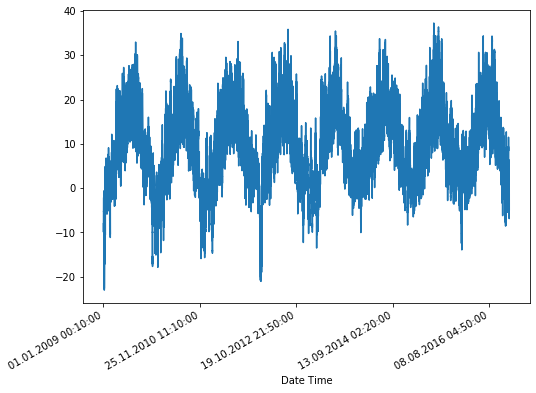

In [269]:
uni_data.plot(subplots=True)

In [270]:
uni_data = uni_data.values

In [271]:
#The mean and standard deviation should only be computed using the training data.
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [272]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [273]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [274]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [275]:
def create_time_steps(length):
    return list(range(-length, 0))


In [276]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i,x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
            
        
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel("Time-Step")
    return plt

<module 'matplotlib.pyplot' from '/home/joel/anaconda3/envs/MSDS422/lib/python3.7/site-packages/matplotlib/pyplot.py'>

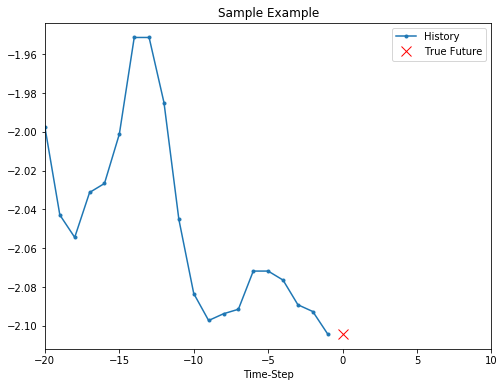

In [277]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [278]:
def baseline(history):
    return np.mean(history)


<module 'matplotlib.pyplot' from '/home/joel/anaconda3/envs/MSDS422/lib/python3.7/site-packages/matplotlib/pyplot.py'>

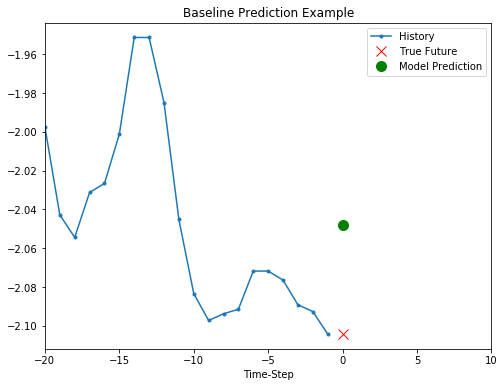

In [279]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')


In [280]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

val_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [281]:
y_val_uni

array([ 0.59938767,  0.59938767,  0.59938767, ..., -1.43494935,
       -1.55883897, -1.62715193])

In [282]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')


In [283]:
#simple_lstm_model = generateModel1()
print(simple_lstm_model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
None


In [284]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)


(256, 1)


In [285]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)


Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 21ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0287 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [===========================

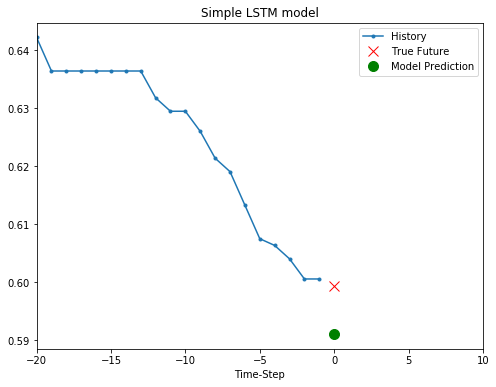

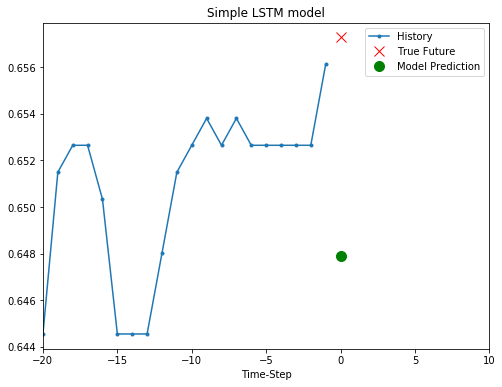

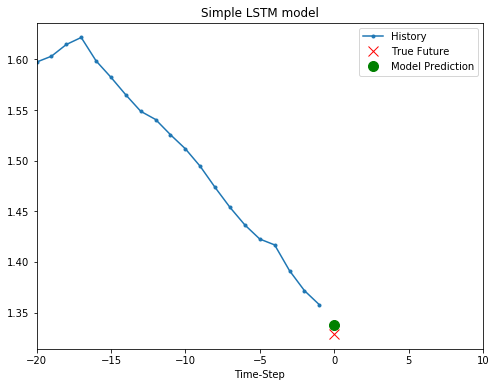

In [286]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [287]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [288]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbab137a650>,
      dtype=object)

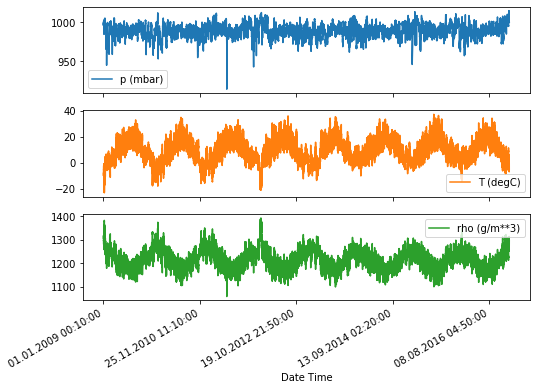

In [289]:
features.plot(subplots=True)

In [290]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [291]:
dataset = (dataset-data_mean)/data_std

In [293]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [294]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [295]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [296]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [297]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [298]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [299]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 31s 156ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2623 - val_loss: 0.2448
Epoch 3/10
200/200 [==============================] - 26s 132ms/step - loss: 0.2613 - val_loss: 0.2464
Epoch 4/10
200/200 [==============================] - 27s 135ms/step - loss: 0.2569 - val_loss: 0.2465
Epoch 5/10
200/200 [==============================] - 27s 137ms/step - loss: 0.2262 - val_loss: 0.2354
Epoch 6/10
200/200 [==============================] - 27s 134ms/step - loss: 0.2416 - val_loss: 0.2650
Epoch 7/10
200/200 [==============================] - 25s 124ms/step - loss: 0.2412 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 27s 137ms/step - loss: 0.2409 - val_loss: 0.2391
Epoch 9/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2453 - val_loss: 0.2466
Epoch 10/10
200/200 [=========

In [300]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

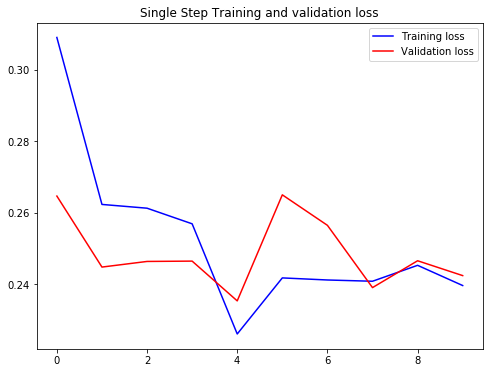

In [301]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

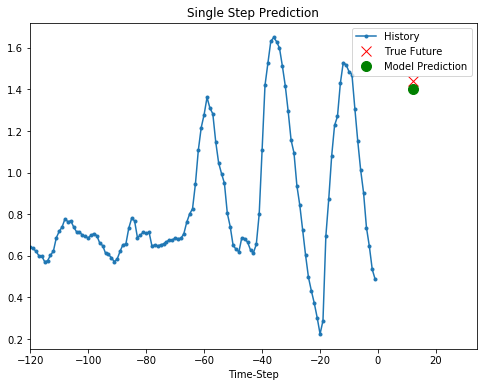

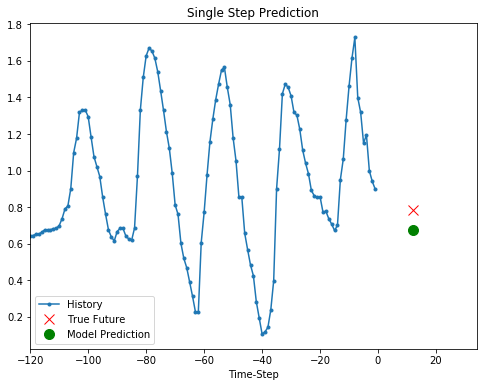

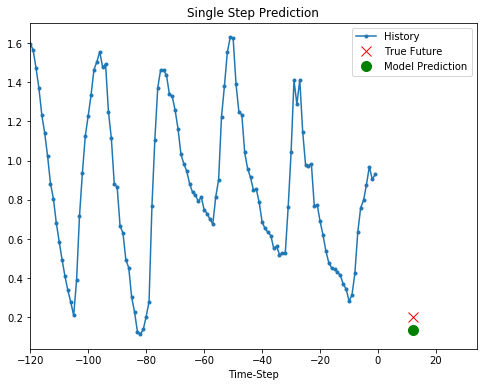

In [302]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                     single_step_model.predict(x)[0]], 12,
                     'Single Step Prediction')
    plot.show()

In [303]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [304]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [305]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [306]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

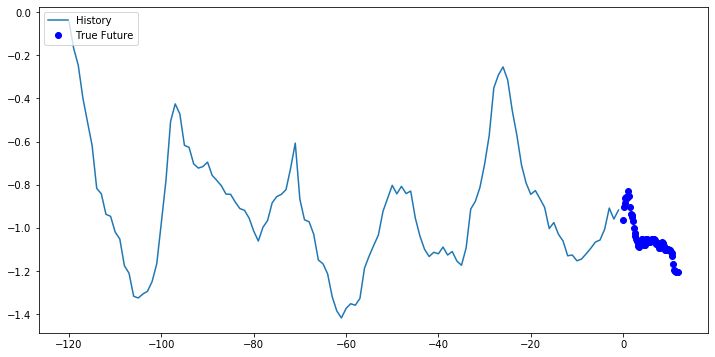

In [307]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [308]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [309]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [310]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 51s 253ms/step - loss: 0.4962 - val_loss: 0.3010
Epoch 2/10
200/200 [==============================] - 44s 220ms/step - loss: 0.3479 - val_loss: 0.2833
Epoch 3/10
200/200 [==============================] - 43s 214ms/step - loss: 0.3343 - val_loss: 0.2566
Epoch 4/10
200/200 [==============================] - 43s 216ms/step - loss: 0.2441 - val_loss: 0.2088
Epoch 5/10
200/200 [==============================] - 42s 210ms/step - loss: 0.1966 - val_loss: 0.2027
Epoch 6/10
200/200 [==============================] - 47s 234ms/step - loss: 0.2060 - val_loss: 0.2102
Epoch 7/10
200/200 [==============================] - 45s 224ms/step - loss: 0.1982 - val_loss: 0.2047
Epoch 8/10
200/200 [==============================] - 45s 224ms/step - loss: 0.1961 - val_loss: 0.2039
Epoch 9/10
200/200 [==============================] - 43s 213ms/step - loss: 0.1979 - val_loss: 0.1880
Epoch 10/10
200/200 [=========

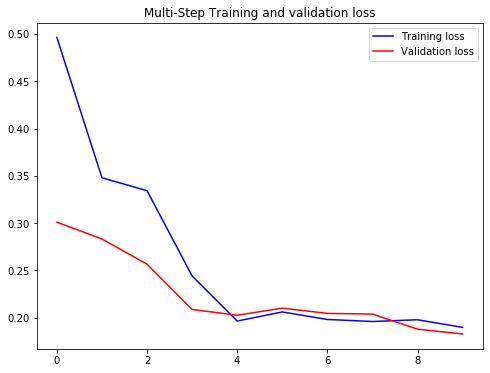

In [311]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

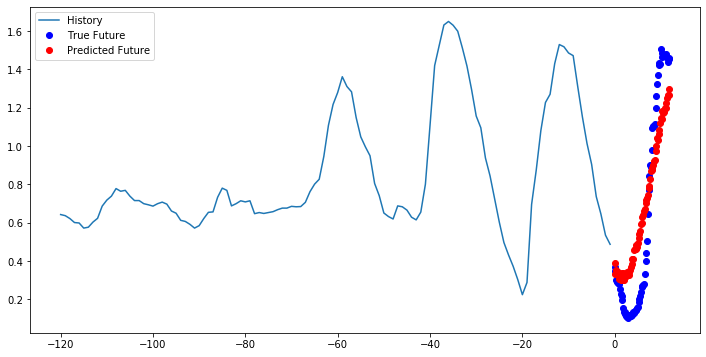

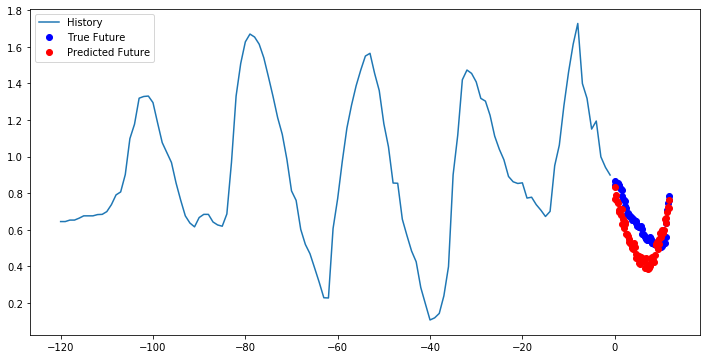

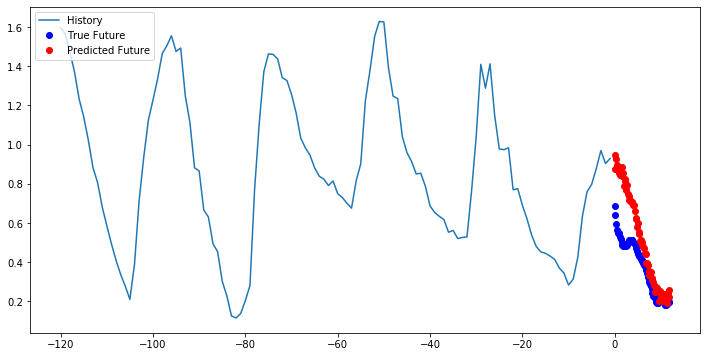

In [312]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])